In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

import librosa
import librosa.display
from IPython.display import Audio
import warnings


import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint




warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"

In [4]:
ravdess_directory_list = os.listdir(Ravdess)
file_emotion = []

file_path = []
for i in ravdess_directory_list:
    actor = os.listdir(Ravdess +"/"+ i)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file is emotion
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess+"/" + i + '/' + file)

# list to dataframe
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])

# Combining
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# int to emotion
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgusted', 8:'surprised'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,surprised,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgusted,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgusted,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...


In [5]:
Ravdess_df["Emotions"].value_counts()

Emotions
surprised    192
disgusted    192
fear         192
sad          192
calm         192
happy        192
angry        192
neutral       96
Name: count, dtype: int64

In [6]:
# creating Dataframe using above 3 dataframes.
df = pd.concat([Ravdess_df], axis = 0)
df.to_csv("data.csv",index=False)
df.head()

,Emotions,Path
0,surprised,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgusted,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgusted,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...


In [8]:
df.reset_index(drop=True,inplace=True)
df["Emotions"].value_counts()

Emotions
surprised    192
disgusted    192
fear         192
sad          192
calm         192
happy        192
angry        192
neutral       96
Name: count, dtype: int64

Text(0.5, 1.0, 'Count of Emotions')

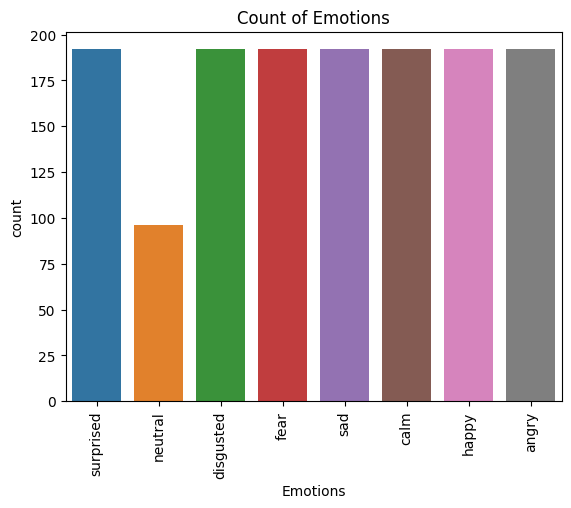

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.xticks( rotation='vertical')
sns.countplot(data=df, x="Emotions")
plt.title("Count of Emotions")

In [10]:
def waveplot(data,sr,emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion,size=20)
    librosa.display.waveshow(data,sr=sr)
    plt.show()

def spectogram(data,sr,emotion):
    x=librosa.stft(data)
    xdb=librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion,size=20)
    librosa.display.specshow(xdb,sr=sr,x_axis="time",y_axis="hz")
    plt.colorbar()

In [11]:
emot=["disgusted","fear","sad","happy","angry","neutral","surprised","calm"]

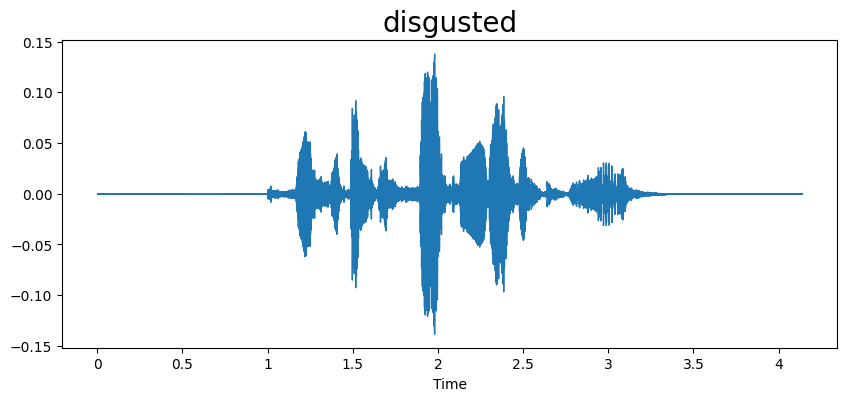

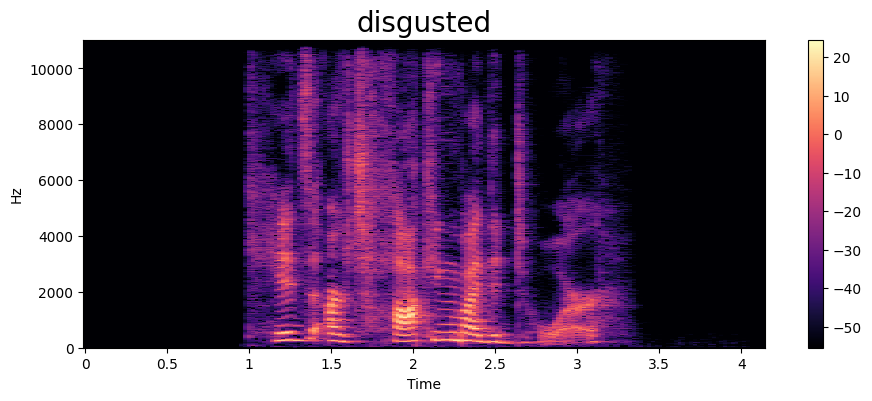

In [13]:
# had to downgrade the numba verison so that its version matches with numpy and being compatible
emotion=emot[0]
path=np.array(df["Path"][df["Emotions"]==emotion])[0]
data,sampling_rate=librosa.load(path)

waveplot(data,sampling_rate,emotion) #calling fuction of waveform
spectogram(data,sampling_rate,emotion) #calling function of spectrogram
Audio(path) #audio to hear in the output

#similarly for all 8 different emotions

In [14]:
#for providing more accurate values, the augmented data is to be fed to the neural network.
def noise(data):
    noise_amp = 0.030*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.75):
    return librosa.effects.time_stretch(data,rate=0.75)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.75):
    return librosa.effects.pitch_shift(data,sr=sampling_rate, n_steps=0.75) #sr and n_steps are syntax,dont change them

#just to check the augmentation techniques
path = np.array(df.Path)[1]
data, sample_rate = librosa.load(path)

In [15]:
#for providing more accurate values, the augmented data is to be fed to the neural network.
def noise(data):
    noise_amp = 0.030*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.75):
    return librosa.effects.time_stretch(data,rate=0.75)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.75):
    return librosa.effects.pitch_shift(data,sr=sampling_rate, n_steps=0.75) #sr and n_steps are syntax,dont change them

#just to check the augmentation techniques
path = np.array(df.Path)[1]
data, sample_rate = librosa.load(path)

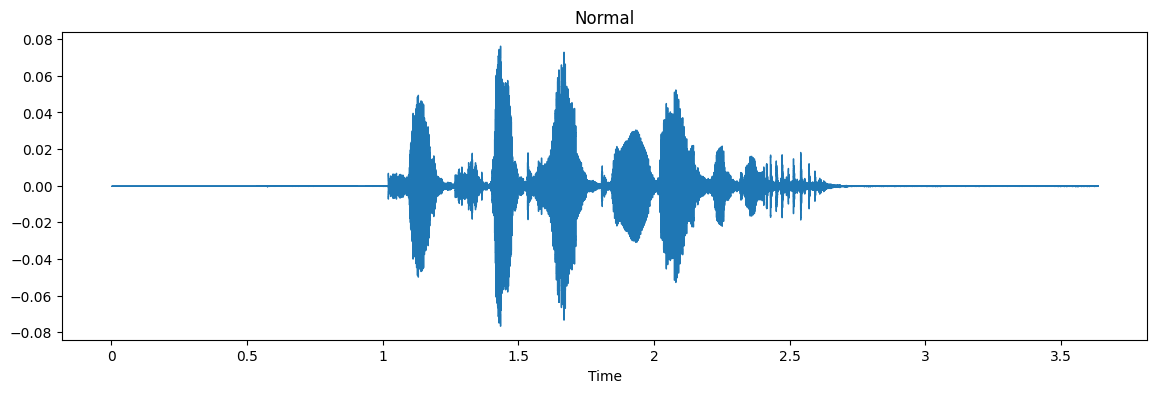

In [17]:
# normal
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
plt.title("Normal")
Audio(path)
#similarly for all augmentations

In [18]:
# Feature extraction
def extract_features(data, sample_rate):
    result = np.array([])

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13).T, axis=0)
    result = np.hstack((result, mfcc))

    # Mel-scaled Spectrogram
    mel_spectrogram = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel_spectrogram))

    # Chromagram
    chroma = np.mean(librosa.feature.chroma_stft(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma))

    # Spectral Contrast
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, spectral_contrast))

    # Tonnetz
    tonnetz = np.mean(librosa.feature.tonnetz(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, tonnetz))

    return result
def get_features(path):
    # duration and offset are used to take care of
    # the no audio in the start and the ending of each audio file as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # with noise (assuming noise function is defined)
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2))

    # stretching and pitching (assuming stretch and pitch functions are defined)
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch, sample_rate)
    result = np.vstack((result, res3))

    return result


In [19]:
#interrupted the kernel as it takes several hours
X, Y = [], []

di=zip(df["Path"], df["Emotions"])
for path, emotion in di :
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [20]:
len(X), len(Y), df["Path"].shape

(4320, 4320, (1440,))

In [21]:
new_df = pd.DataFrame(X)
new_df['Emotions'] = Y
new_df.to_csv('dataframe.csv', index=False)
new_df.head()

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,Emotions
0,-498.172028,53.171146,-22.092066,11.496428,-10.811963,-12.038263,-5.335874,-8.586675,-4.736596,-5.701678,...,16.723265,17.657388,44.401003,-0.020806,0.003024,-0.034787,-0.021998,0.009800,0.007162,surprised
1,-453.962006,42.836739,-19.350994,6.690493,-11.277754,-11.480747,-5.850787,-7.385928,-6.059562,-5.953951,...,16.387199,16.644076,15.853440,-0.011827,0.005672,-0.027125,-0.016422,0.005131,0.006386,surprised
2,-552.780518,50.727905,-24.478201,10.399164,-16.264717,-11.686041,-7.868933,-9.462960,-6.175901,-6.843550,...,18.916236,19.543074,47.864027,-0.023815,-0.005784,0.015288,-0.034541,0.009824,-0.001201,surprised
3,-573.702881,74.766006,-16.835482,9.510839,-8.442752,-7.398401,-9.191017,-13.571818,-6.444541,-1.531598,...,18.252310,18.054687,45.921423,-0.038259,0.020773,0.017420,-0.040932,0.012243,0.006729,neutral
4,-381.772861,23.839256,-1.198221,-1.375345,-4.126328,-5.909718,-6.723812,-7.827739,-4.801553,-1.784649,...,15.315287,14.132665,13.678528,-0.018122,0.016851,0.014984,-0.026662,0.008291,0.003281,neutral


In [22]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Dropout, Flatten, Dense, Activation
from keras.optimizers import RMSprop
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np


In [23]:
# Load your data
X = new_df.iloc[:, :-1].values
Y = new_df['Emotions'].values

# One-hot encode the target variable
encoder = OneHotEncoder()
Y_encoded = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()

# Initialize the StratifiedKFold cross-validator
num_folds = 5
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)


In [25]:
def create_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv1D(256, kernel_size=5, strides=1, input_shape=input_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv1D(128, kernel_size=5, strides=1, padding='same'))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=8))

    model.add(Conv1D(128, kernel_size=5, strides=1, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv1D(128, kernel_size=5, strides=1, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv1D(128, kernel_size=5, strides=1, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(0.2))

    model.add(Dense(num_classes))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))

    optimizer = RMSprop(learning_rate=0.00001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Example usage:
input_shape = (X.shape[1], 1)   # Adjust based on your input features
num_classes = 8  # Adjust based on the number of emotion classes
model = create_model(input_shape, num_classes)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 166, 256)          1536      
                                                                 
 batch_normalization (Batch  (None, 166, 256)          1024      
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 166, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 166, 256)          327936    
                                                                 
 batch_normalization_1 (Bat  (None, 166, 256)          1024      
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 166, 256)          0


Training on Fold 1/5
Epoch 1/700
108/108 - 8s - loss: 2.3183 - accuracy: 0.1560 - val_loss: 2.0740 - val_accuracy: 0.1875 - 8s/epoch - 71ms/step
Epoch 2/700
108/108 - 1s - loss: 2.1750 - accuracy: 0.1965 - val_loss: 2.0259 - val_accuracy: 0.1782 - 993ms/epoch - 9ms/step
Epoch 3/700
108/108 - 1s - loss: 2.0707 - accuracy: 0.2208 - val_loss: 1.9526 - val_accuracy: 0.2512 - 988ms/epoch - 9ms/step
Epoch 4/700
108/108 - 1s - loss: 1.9984 - accuracy: 0.2312 - val_loss: 1.9113 - val_accuracy: 0.2454 - 995ms/epoch - 9ms/step
Epoch 5/700
108/108 - 1s - loss: 1.9649 - accuracy: 0.2523 - val_loss: 1.8541 - val_accuracy: 0.2627 - 995ms/epoch - 9ms/step
Epoch 6/700
108/108 - 1s - loss: 1.9306 - accuracy: 0.2520 - val_loss: 1.8093 - val_accuracy: 0.2963 - 983ms/epoch - 9ms/step
Epoch 7/700
108/108 - 1s - loss: 1.8876 - accuracy: 0.2760 - val_loss: 1.7633 - val_accuracy: 0.3137 - 1s/epoch - 9ms/step
Epoch 8/700
108/108 - 1s - loss: 1.8714 - accuracy: 0.2769 - val_loss: 1.7453 - val_accuracy: 0.3252 

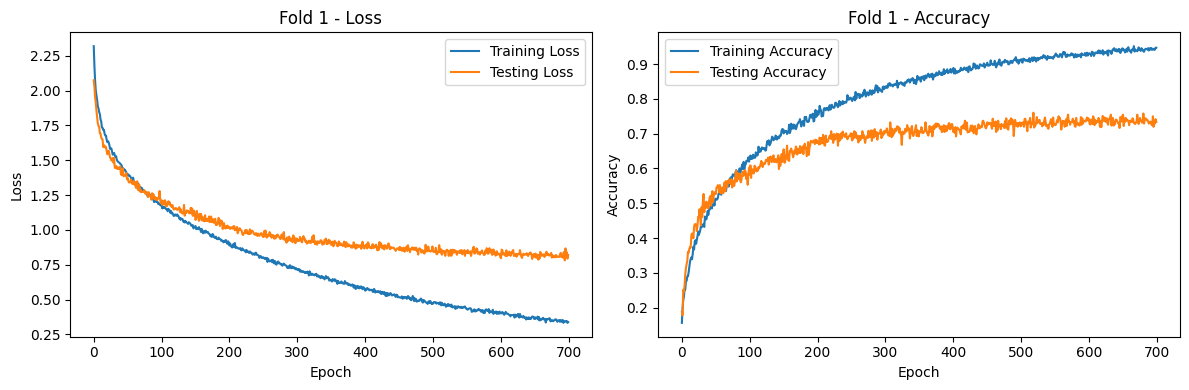


Training on Fold 2/5
Epoch 1/700
108/108 - 6s - loss: 2.3232 - accuracy: 0.1649 - val_loss: 2.1043 - val_accuracy: 0.1725 - 6s/epoch - 55ms/step
Epoch 2/700
108/108 - 1s - loss: 2.1441 - accuracy: 0.2037 - val_loss: 2.0847 - val_accuracy: 0.2060 - 982ms/epoch - 9ms/step
Epoch 3/700
108/108 - 1s - loss: 2.1095 - accuracy: 0.2182 - val_loss: 2.0021 - val_accuracy: 0.2176 - 980ms/epoch - 9ms/step
Epoch 4/700
108/108 - 1s - loss: 2.0261 - accuracy: 0.2266 - val_loss: 1.9223 - val_accuracy: 0.2234 - 980ms/epoch - 9ms/step
Epoch 5/700
108/108 - 1s - loss: 1.9993 - accuracy: 0.2318 - val_loss: 1.8468 - val_accuracy: 0.2465 - 980ms/epoch - 9ms/step
Epoch 6/700
108/108 - 1s - loss: 1.9508 - accuracy: 0.2399 - val_loss: 1.7905 - val_accuracy: 0.2847 - 983ms/epoch - 9ms/step
Epoch 7/700
108/108 - 1s - loss: 1.9226 - accuracy: 0.2538 - val_loss: 1.7491 - val_accuracy: 0.3368 - 990ms/epoch - 9ms/step
Epoch 8/700
108/108 - 1s - loss: 1.8838 - accuracy: 0.2650 - val_loss: 1.7216 - val_accuracy: 0.33

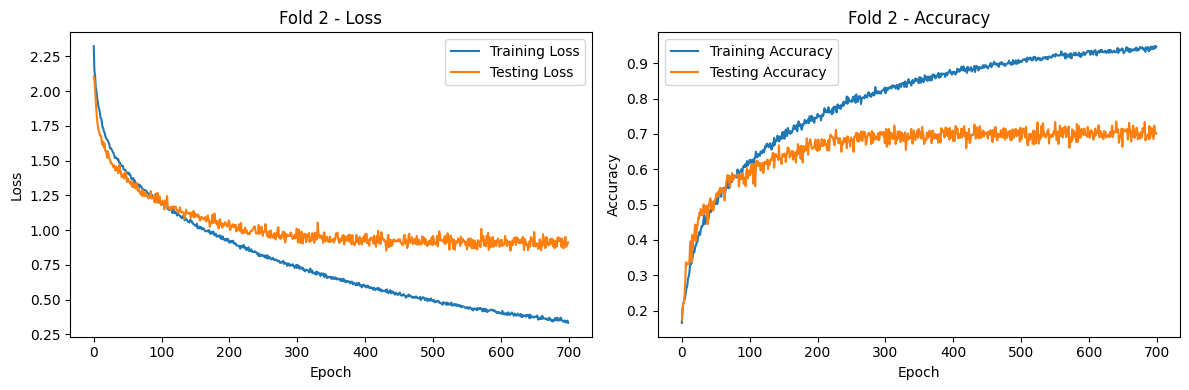


Training on Fold 3/5
Epoch 1/700
108/108 - 6s - loss: 2.3453 - accuracy: 0.1542 - val_loss: 2.0503 - val_accuracy: 0.1470 - 6s/epoch - 51ms/step
Epoch 2/700
108/108 - 1s - loss: 2.1770 - accuracy: 0.2043 - val_loss: 1.9821 - val_accuracy: 0.1898 - 970ms/epoch - 9ms/step
Epoch 3/700
108/108 - 1s - loss: 2.0690 - accuracy: 0.2222 - val_loss: 1.8899 - val_accuracy: 0.2535 - 983ms/epoch - 9ms/step
Epoch 4/700
108/108 - 1s - loss: 2.0295 - accuracy: 0.2248 - val_loss: 1.8438 - val_accuracy: 0.2535 - 968ms/epoch - 9ms/step
Epoch 5/700
108/108 - 1s - loss: 1.9633 - accuracy: 0.2344 - val_loss: 1.7790 - val_accuracy: 0.3009 - 968ms/epoch - 9ms/step
Epoch 6/700
108/108 - 1s - loss: 1.9268 - accuracy: 0.2535 - val_loss: 1.7629 - val_accuracy: 0.2731 - 969ms/epoch - 9ms/step
Epoch 7/700
108/108 - 1s - loss: 1.8865 - accuracy: 0.2624 - val_loss: 1.7503 - val_accuracy: 0.3021 - 974ms/epoch - 9ms/step
Epoch 8/700
108/108 - 1s - loss: 1.8623 - accuracy: 0.2844 - val_loss: 1.7117 - val_accuracy: 0.35

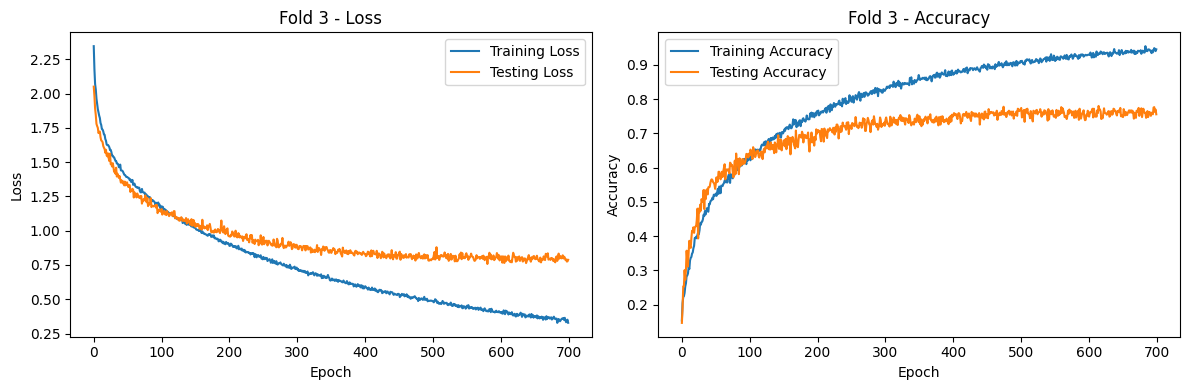


Training on Fold 4/5
Epoch 1/700
108/108 - 5s - loss: 2.3189 - accuracy: 0.1583 - val_loss: 2.0876 - val_accuracy: 0.1262 - 5s/epoch - 51ms/step
Epoch 2/700
108/108 - 1s - loss: 2.1705 - accuracy: 0.2011 - val_loss: 2.0377 - val_accuracy: 0.2130 - 976ms/epoch - 9ms/step
Epoch 3/700
108/108 - 1s - loss: 2.0963 - accuracy: 0.2199 - val_loss: 1.9694 - val_accuracy: 0.2662 - 982ms/epoch - 9ms/step
Epoch 4/700
108/108 - 1s - loss: 2.0407 - accuracy: 0.2228 - val_loss: 1.9040 - val_accuracy: 0.2917 - 977ms/epoch - 9ms/step
Epoch 5/700
108/108 - 1s - loss: 1.9870 - accuracy: 0.2538 - val_loss: 1.8207 - val_accuracy: 0.3356 - 978ms/epoch - 9ms/step
Epoch 6/700
108/108 - 1s - loss: 1.9363 - accuracy: 0.2714 - val_loss: 1.7643 - val_accuracy: 0.3461 - 977ms/epoch - 9ms/step
Epoch 7/700
108/108 - 1s - loss: 1.9028 - accuracy: 0.2639 - val_loss: 1.7413 - val_accuracy: 0.3530 - 975ms/epoch - 9ms/step
Epoch 8/700
108/108 - 1s - loss: 1.8446 - accuracy: 0.2853 - val_loss: 1.7349 - val_accuracy: 0.35

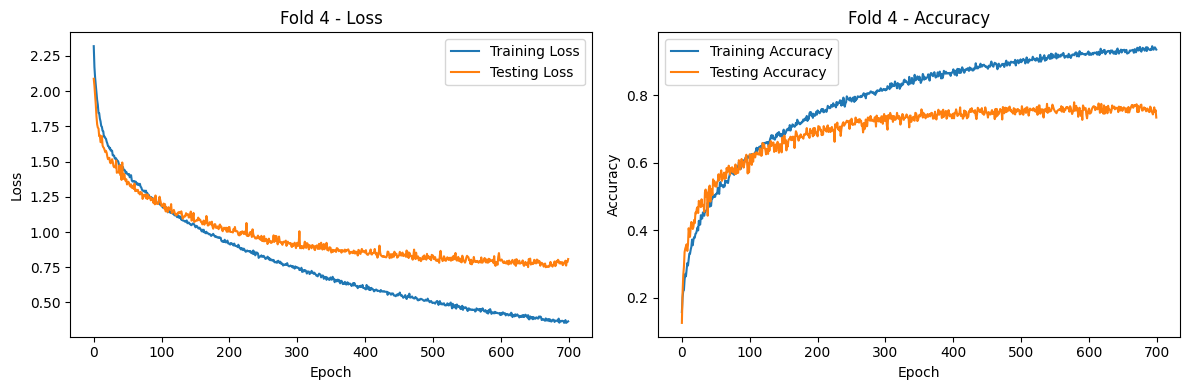


Training on Fold 5/5
Epoch 1/700
108/108 - 6s - loss: 2.4077 - accuracy: 0.1493 - val_loss: 2.1008 - val_accuracy: 0.1424 - 6s/epoch - 51ms/step
Epoch 2/700
108/108 - 1s - loss: 2.2019 - accuracy: 0.1953 - val_loss: 2.0314 - val_accuracy: 0.2188 - 983ms/epoch - 9ms/step
Epoch 3/700
108/108 - 1s - loss: 2.1002 - accuracy: 0.2104 - val_loss: 1.9528 - val_accuracy: 0.2211 - 978ms/epoch - 9ms/step
Epoch 4/700
108/108 - 1s - loss: 2.0389 - accuracy: 0.2306 - val_loss: 1.9265 - val_accuracy: 0.2292 - 978ms/epoch - 9ms/step
Epoch 5/700
108/108 - 1s - loss: 1.9959 - accuracy: 0.2370 - val_loss: 1.9072 - val_accuracy: 0.2581 - 978ms/epoch - 9ms/step
Epoch 6/700
108/108 - 1s - loss: 1.9613 - accuracy: 0.2436 - val_loss: 1.8778 - val_accuracy: 0.2743 - 994ms/epoch - 9ms/step
Epoch 7/700
108/108 - 1s - loss: 1.9026 - accuracy: 0.2541 - val_loss: 1.8259 - val_accuracy: 0.3056 - 979ms/epoch - 9ms/step
Epoch 8/700
108/108 - 1s - loss: 1.8902 - accuracy: 0.2656 - val_loss: 1.8331 - val_accuracy: 0.28

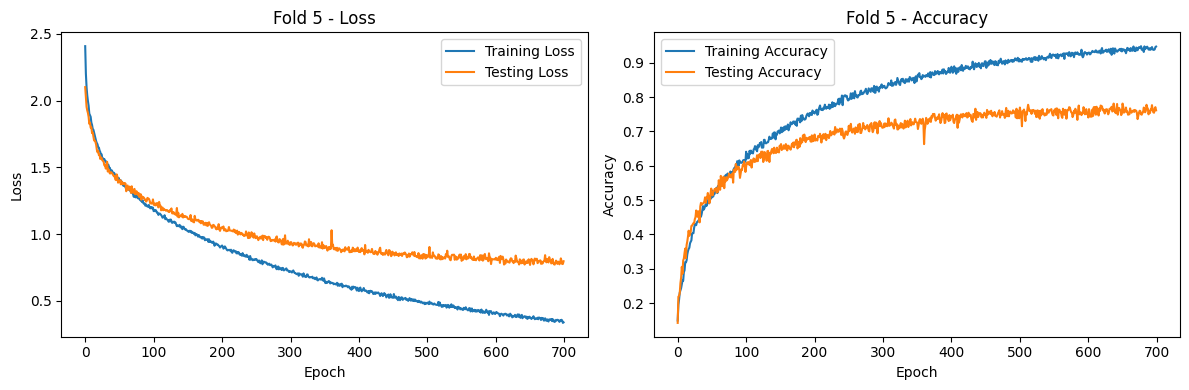


Average Training Accuracy: 98.81% | Average Testing Accuracy: 73.73%


In [31]:
# Initialize variables to store results
all_train_labels = []
all_train_predictions = []
all_test_labels = []
all_test_predictions = []

# Loop through the folds
for fold, (train_index, test_index) in enumerate(kf.split(X, Y)):
    print(f"\nTraining on Fold {fold + 1}/{num_folds}")

    # Split the data into training and testing sets
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y_encoded[train_index], Y_encoded[test_index]

    # Standardize the input features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # making our data compatible to model.
    X_train_scaled = np.expand_dims(X_train, axis=2)
    X_test_scaled = np.expand_dims(X_test, axis=2)

    # Create the model
    input_shape = (X_train_scaled.shape[1], 1)  # Adjust based on your input features
    num_classes = Y_train.shape[1]  # Adjust based on the number of emotion classes
    model = create_model(input_shape, num_classes)

    # Train the model and obtain the training history
    history = model.fit(X_train_scaled, Y_train, epochs=700, batch_size=32, verbose=2, validation_data=(X_test_scaled, Y_test))

    # Evaluate on the training set
    train_predictions = model.predict(X_train_scaled)
    train_labels = np.argmax(Y_train, axis=1)

    # Evaluate on the test set
    test_predictions = model.predict(X_test_scaled)
    test_labels = np.argmax(Y_test, axis=1)

    # Store results for later analysis
    all_train_labels.extend(train_labels)
    all_train_predictions.extend(np.argmax(train_predictions, axis=1))
    all_test_labels.extend(test_labels)
    all_test_predictions.extend(np.argmax(test_predictions, axis=1))

    # Print accuracies for this fold
    train_accuracy = accuracy_score(train_labels, np.argmax(train_predictions, axis=1))
    test_accuracy = accuracy_score(test_labels, np.argmax(test_predictions, axis=1))
    print(f"Fold {fold + 1} - Training Accuracy: {train_accuracy * 100:.2f}% | Testing Accuracy: {test_accuracy * 100:.2f}%")

    # Plot training and testing loss
    plt.figure(figsize=(12, 4))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Testing Loss')
    plt.title(f'Fold {fold + 1} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
    plt.title(f'Fold {fold + 1} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Calculate and print average training and testing accuracies
avg_train_accuracy = accuracy_score(all_train_labels, all_train_predictions)
avg_test_accuracy = accuracy_score(all_test_labels, all_test_predictions)
print(f"\nAverage Training Accuracy: {avg_train_accuracy * 100:.2f}% | Average Testing Accuracy: {avg_test_accuracy * 100:.2f}%")


In [34]:
# predicting on test data.
pred_test = model.predict(X_test_scaled )
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(Y_test)

27/27 [==============================] - 0s 3ms/step


In [ ]:
# all these predictions and the confusion matrix was given under last fold accuracy values. have to modify the code in testing function in order to get confusion matrix of each fold.

In [35]:
c_df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
c_df['Predicted Labels'] = y_pred.flatten()
c_df['Actual Labels'] = y_test.flatten()

In [36]:
c_df.sample(10)

,Predicted Labels,Actual Labels
599,fear,fear
767,surprised,surprised
823,angry,disgusted
833,neutral,calm
416,disgusted,surprised
476,neutral,neutral
4,disgusted,disgusted
457,calm,calm
379,sad,sad
406,disgusted,disgusted


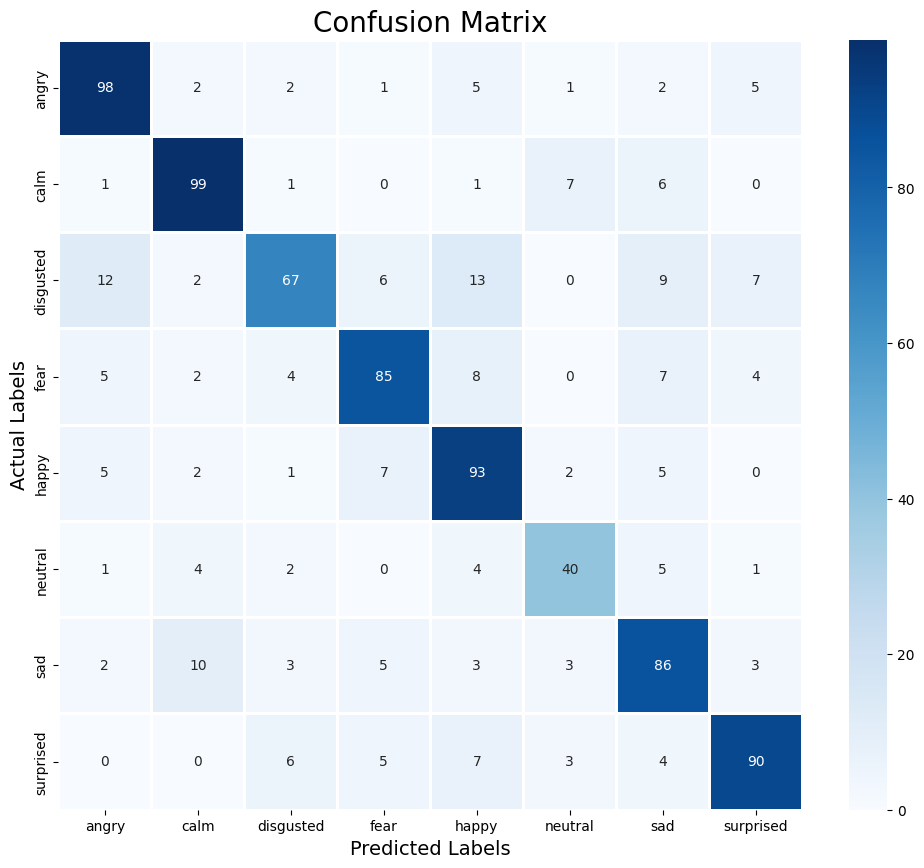

In [37]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.79      0.84      0.82       116
        calm       0.82      0.86      0.84       115
   disgusted       0.78      0.58      0.66       116
        fear       0.78      0.74      0.76       115
       happy       0.69      0.81      0.75       115
     neutral       0.71      0.70      0.71        57
         sad       0.69      0.75      0.72       115
   surprised       0.82      0.78      0.80       115

    accuracy                           0.76       864
   macro avg       0.76      0.76      0.76       864
weighted avg       0.76      0.76      0.76       864

